# Denoising Autoencoders

In this final lab, we will look at using a denoising autoencoder to remove noise from images. We will use the Fashion MNIST dataset and add noise to the images. We will then train a denoising autoencoder to remove the noise from the images.

Fashion MNIST is a dataset of low resolution images of clothes. It is a popular dataset for image classification and is often used as a drop-in replacement for the original MNIST dataset.

Let's start by loading the dataset and looking at some examples. You'll note that unlike previous labs, we are not even loading the labels! This is because we are going to use the images as both the input and the output of the model.

In [1]:
import tensorflow as tf

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

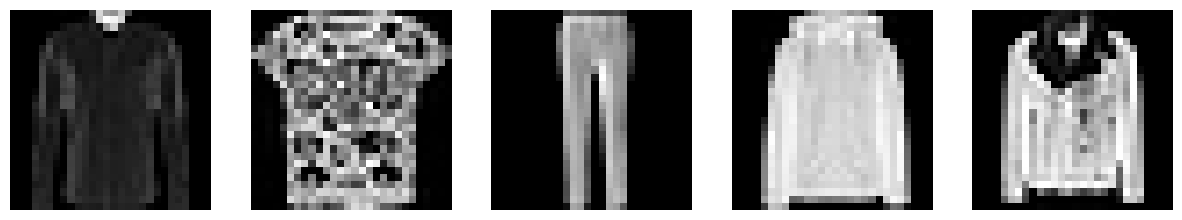

In [2]:
import matplotlib.pyplot as plt
from random import choice

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    ax = axs[i]
    ax.imshow(x_train[choice(range(len(x_train)))], cmap='gray')
    ax.axis('off')
    
plt.show()

# Adding Noise

Because our model will be trained to remove noise from the images, we need to add noise to the images. We will use a simple method of adding Gaussian noise to the images. We will then clip the values to be between 0 and 1.

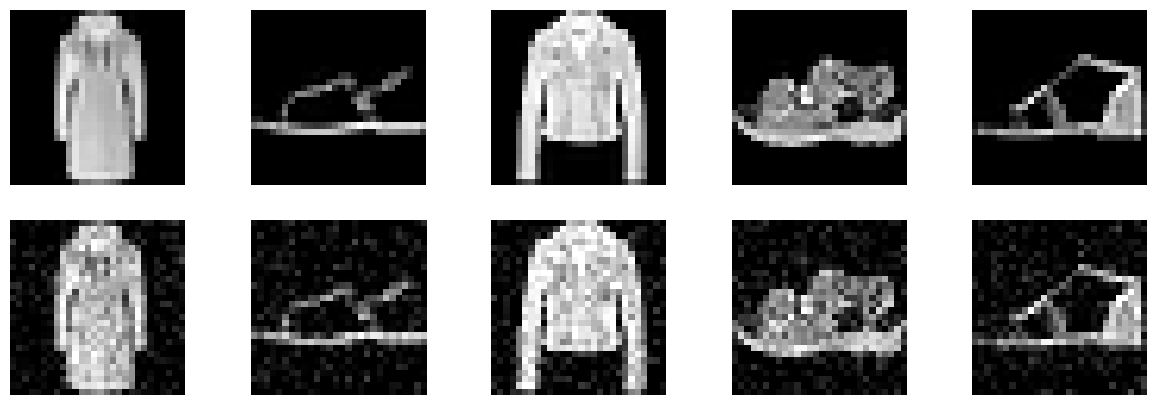

In [5]:
import numpy as np

def add_noise(x, noise_factor=0.1):
    x = x + np.random.normal(loc=0.0, scale=noise_factor, size=x.shape)
    return np.clip(x, 0., 1.)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
    ax = axs[0, i]
    idx = choice(range(len(x_train)))
    ax.imshow(x_train[idx], cmap='gray')
    ax.axis('off')
    
    ax = axs[1, i]
    ax.imshow(x_train_noisy[idx], cmap='gray')
    ax.axis('off')
    
plt.show()

# Building the Model

Now, let's build a simple autoencoder. This type of model is comprised of two main parts: the encoder and the decoder. The encoder will compress the input image into a lower dimensional representation, and the decoder will attempt to recreate the original image from this lower dimensional representation.

We have completed the encoder for you. It is a simple model that flattens the input image and then passes it through two dense layers. The decoder is your task to complete. It should take the output of the encoder and attempt to recreate the original image.

**Note:** we are used to squashing the output of our model to be between 0 and 1, either with softmax or sigmoid depending on the use case. However, this should not apply to the output of our encoder! The encoder is not outputting a probability, but rather a representation of the input. As such, we should use an activation function like `relu` for the dense layers of the encoder. The decoder, however, should use `sigmoid` to squash the output to be between 0 and 1.

In [8]:
from tensorflow.keras import layers, models

encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu')
])

decoder = models.Sequential([
    # Add layers to accept the output of the encoder and attempt to recreate the original image.
    layers.Dense(128, activation='relu', input_shape=(64,)),
    layers.Dense(28 * 28, activation='sigmoid'),
    # The layers should be the reverse of the encoder.
    layers.Reshape((28, 28))
])

autoencoder = models.Sequential([
    encoder,
    decoder
])

We will use binary cross-entropy as the loss function, as we are treating the model as a simple logistic regression model. We will use the Adam optimizer to train the model.

In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 64)                108736    
                                                                 
 sequential_8 (Sequential)   (None, 28, 28)            109456    
                                                                 
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Special callback to visualize the training progress
from tensorflow.keras.callbacks import Callback

def plot_image(i):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].imshow(x_test[i], cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(x_test_noisy[i], cmap='gray')
    axs[1].set_title('Noisy')
    axs[1].axis('off')

    axs[2].imshow(autoencoder.predict(x_test_noisy[[i]])[0], cmap='gray')
    axs[2].set_title('De-noised')
    axs[2].axis('off')

    plt.show()

class VisualizeCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        plot_image(3)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss'),
        ModelCheckpoint('autoencoder', save_best_only=True)
    ]
)

Epoch 1/50
422/422 [==============================] - 7s 16ms/step - loss: 0.2767 - val_loss: 0.2792
Epoch 2/50
422/422 [==============================] - 7s 16ms/step - loss: 0.2759 - val_loss: 0.2781
Epoch 3/50
422/422 [==============================] - 6s 15ms/step - loss: 0.2751 - val_loss: 0.2776
Epoch 4/50
422/422 [==============================] - 6s 15ms/step - loss: 0.2745 - val_loss: 0.2768
Epoch 5/50
422/422 [==============================] - 6s 15ms/step - loss: 0.2739 - val_loss: 0.2762
Epoch 6/50
422/422 [==============================] - 7s 16ms/step - loss: 0.2734 - val_loss: 0.2757
Epoch 7/50
422/422 [==============================] - 7s 16ms/step - loss: 0.2730 - val_loss: 0.2754
Epoch 8/50
422/422 [==============================] - 7s 15ms/step - loss: 0.2725 - val_loss: 0.2750
Epoch 9/50
422/422 [==============================] - 7s 16ms/step - loss: 0.2722 - val_loss: 0.2748
Epoch 10/50
422/422 [==============================] - 7s 16ms/step - loss: 0.2718 - val_lo

In [13]:
# Load the best model

autoencoder = models.load_model('autoencoder')

# Evaluating the Model

Now that we have trained the model, let's see how well it can remove noise from the images. Use the `plot_image` method to visualize the original images, the noisy images, and the denoised images.

1/1 [==============================] - 0s 149ms/step


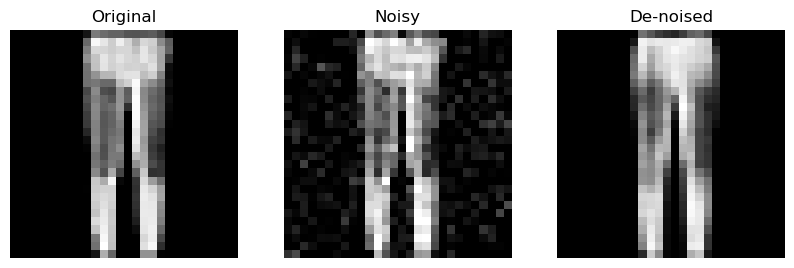

In [14]:
plot_image(3)

# Using Autoencoders for Dimensionality Reduction

During the course, we've looked at standard techniques for dimensionality reduction - PCA and t-SNE. We can also use autoencoders for dimensionality reduction. The output of our encoder is a lower-dimensional representation of the input, which is used by the decoder to recreate that input. As a result, we can use just the encoder to get a low-dimensional representation of our input data.

In the code below, modify your encoder and decoder so that the encoder outputs a 2-dimensional representation of the input. For this task, we won't use the noisy images to train, since our priority now is creating an accurate representation of the original images. This time we will also work with the labels, but only to visualize the data in 2D.

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [16]:
encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    # Add layers to compress the input image into a 2-dimensional representation
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation=None)
])

decoder = models.Sequential([
    # Add layers to accept the 2-dimensional representation and attempt to recreate the original image.
    layers.Dense(128, activation='relu', input_shape=(2,)),
    layers.Dense(28 * 28, activation='sigmoid'),
    layers.Reshape((28, 28))
])

autoencoder = models.Sequential([
    encoder,
    decoder
])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss'),
        ModelCheckpoint('autoencoder', save_best_only=True)
    ]
)

Epoch 1/50
422/422 [==============================] - 8s 16ms/step - loss: 0.3921 - val_loss: 0.3568
Epoch 2/50
422/422 [==============================] - 6s 15ms/step - loss: 0.3459 - val_loss: 0.3442
Epoch 3/50
422/422 [==============================] - 6s 15ms/step - loss: 0.3381 - val_loss: 0.3400
Epoch 4/50
422/422 [==============================] - 6s 15ms/step - loss: 0.3351 - val_loss: 0.3377
Epoch 5/50
422/422 [==============================] - 6s 14ms/step - loss: 0.3332 - val_loss: 0.3362
Epoch 6/50
422/422 [==============================] - 6s 14ms/step - loss: 0.3318 - val_loss: 0.3345
Epoch 7/50
422/422 [==============================] - 7s 15ms/step - loss: 0.3306 - val_loss: 0.3339
Epoch 8/50
422/422 [==============================] - 7s 16ms/step - loss: 0.3297 - val_loss: 0.3329
Epoch 9/50
422/422 [==============================] - 7s 17ms/step - loss: 0.3290 - val_loss: 0.3318
Epoch 10/50
422/422 [==============================] - 7s 15ms/step - loss: 0.3284 - val_lo

In [18]:
autoencoder = models.load_model('autoencoder')

1/1 [==============================] - 0s 94ms/step


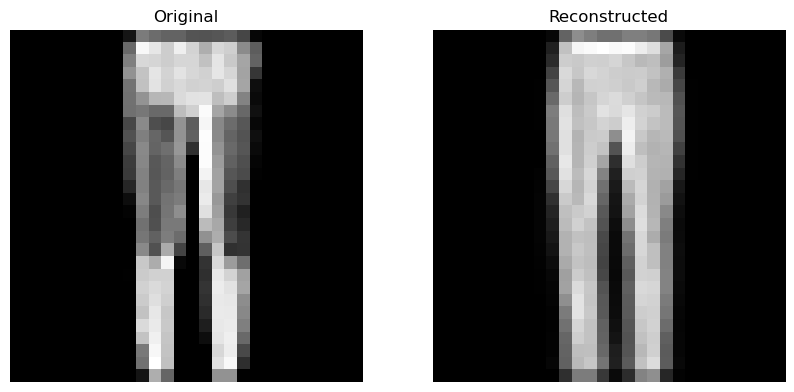

In [19]:
# Visualize reconstruction
def plot_reconstruction(i):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(x_test[i], cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(autoencoder.predict(x_test[[i]])[0], cmap='gray')
    axs[1].set_title('Reconstructed')
    axs[1].axis('off')

    plt.show()
    
plot_reconstruction(3)

313/313 [==============================] - 0s 1ms/step


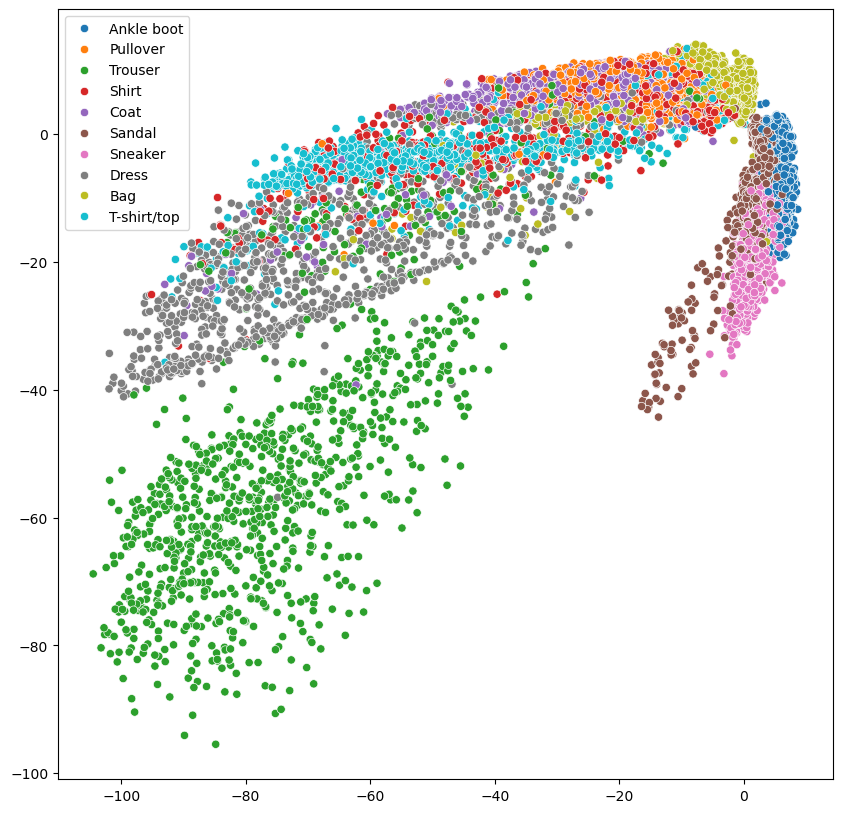

In [20]:
import seaborn as sns

encoded = encoder.predict(x_test)

labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

plt.figure(figsize=(10, 10))
sns.scatterplot(x=encoded[:, 0], y=encoded[:, 1], hue=[labels[i] for i in y_test], palette='tab10')
plt.show()

# Exercises

1. In the first part of the lab, we added Gaussian noise to the images. You can add different types of noise - take a look at some of the options available in numpy [here](https://numpy.org/doc/stable/reference/random/) and try adding different types of noise to the images. How does this affect the performance of the autoencoder?

2. In the second part of the lab, we used the encoder to create a 2-dimensional representation of the input data. We then visualized this representation using a scatter plot. You can also use 3 dimensions instead of 2. How does this affect the reconstruction error? Use the code below to visualize 3D data.

In [21]:
import plotly.express as px

def plot_3d_reconstruction(i):
    """This code assumes that encoded is 3-dimensional."""
    fig = px.scatter_3d(
        x=encoded[:, 0], y=encoded[:, 1], z=encoded[:, 2],
        color=[labels[i] for i in y_test]
    )
    fig.show()

In [22]:
plot_3d_reconstruction(3)

IndexError: index 2 is out of bounds for axis 1 with size 2